In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import graphviz

In [4]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [6]:
from sklearn.metrics import accuracy_score

In [7]:
from dmba import classificationSummary

In [8]:
from sklearn import tree

In [9]:
xlsx = pd.ExcelFile('ebayAuctions.xlsx')

In [10]:
ebay_df = pd.read_excel(xlsx, 'eBay auctions')

Data Cleaning / Exploratory Data Analysis

In [11]:
ebay_df.head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [12]:
#pretty well-balanced data set
ebay_df['Competitive?'].value_counts()

1    1066
0     906
Name: Competitive?, dtype: int64

In [13]:
#most auctions are related to music/movie/game or collectibles or toys/hobbies
ebay_df['Category'].value_counts()

Music/Movie/Game        403
Collectibles            239
Toys/Hobbies            234
Automotive              178
Antique/Art/Craft       177
SportingGoods           124
Clothing/Accessories    119
Home/Garden             102
Jewelry                  82
Health/Beauty            64
Electronics              55
Books                    54
Coins/Stamps             37
Computer                 36
Pottery/Glass            20
Business/Industrial      18
EverythingElse           17
Photography              13
Name: Category, dtype: int64

In [14]:
#majority are US
ebay_df['Currency'].value_counts()

US     1292
EUR     533
GBP     147
Name: Currency, dtype: int64

In [15]:
# there are no null values
ebay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [16]:
#confirming that there are no null values
ebay_df.isna().sum(axis = 'rows')

Category        0
Currency        0
sellerRating    0
Duration        0
endDay          0
ClosePrice      0
OpenPrice       0
Competitive?    0
dtype: int64

In [17]:
#quite a few duplicates - they could be multiple of the same item being put on ebay
sum(ebay_df.duplicated())

346

In [18]:
df_duplicate = ebay_df.duplicated()

In [19]:
#most of duplicates, if they are duplicates, are in music/movie/game, toys/hobbies categories
ebay_df[df_duplicate]['Category'].value_counts()

Music/Movie/Game        117
Toys/Hobbies             56
Collectibles             41
Antique/Art/Craft        32
Automotive               24
Jewelry                  16
Health/Beauty            15
Clothing/Accessories     14
Home/Garden               8
Pottery/Glass             6
SportingGoods             4
Coins/Stamps              4
Electronics               3
EverythingElse            2
Books                     2
Business/Industrial       1
Computer                  1
Name: Category, dtype: int64

In [20]:
#hypothetically if we were to drop the duplicates, although they could be meaningful since a person could post multiple
#auctions for the same item on the same day
ebay_df_no_duplicates = ebay_df.drop_duplicates(keep = 'first')

In [21]:
ebay_df_no_duplicates.head()

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
16,Automotive,US,3115,7,Tue,0.01,0.01,0
20,Automotive,US,3115,7,Tue,0.01,0.01,1
22,Music/Movie/Game,US,37727,7,Mon,0.01,0.01,0
23,Music/Movie/Game,US,3249,5,Mon,0.06,0.01,1


In [22]:
ebay_df_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1626 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1626 non-null   object 
 1   Currency      1626 non-null   object 
 2   sellerRating  1626 non-null   int64  
 3   Duration      1626 non-null   int64  
 4   endDay        1626 non-null   object 
 5   ClosePrice    1626 non-null   float64
 6   OpenPrice     1626 non-null   float64
 7   Competitive?  1626 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 114.3+ KB


In [23]:
#still a decently balanced data set but not as balanced
ebay_df_no_duplicates['Competitive?'].value_counts()

1    999
0    627
Name: Competitive?, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Music/Movie/Game'),
  Text(1, 0, 'Automotive'),
  Text(2, 0, 'Toys/Hobbies'),
  Text(3, 0, 'Collectibles'),
  Text(4, 0, 'Antique/Art/Craft'),
  Text(5, 0, 'Clothing/Accessories'),
  Text(6, 0, 'Health/Beauty'),
  Text(7, 0, 'Jewelry'),
  Text(8, 0, 'Home/Garden'),
  Text(9, 0, 'SportingGoods'),
  Text(10, 0, 'Books'),
  Text(11, 0, 'Coins/Stamps'),
  Text(12, 0, 'EverythingElse'),
  Text(13, 0, 'Pottery/Glass'),
  Text(14, 0, 'Computer'),
  Text(15, 0, 'Electronics'),
  Text(16, 0, 'Business/Industrial'),
  Text(17, 0, 'Photography')])

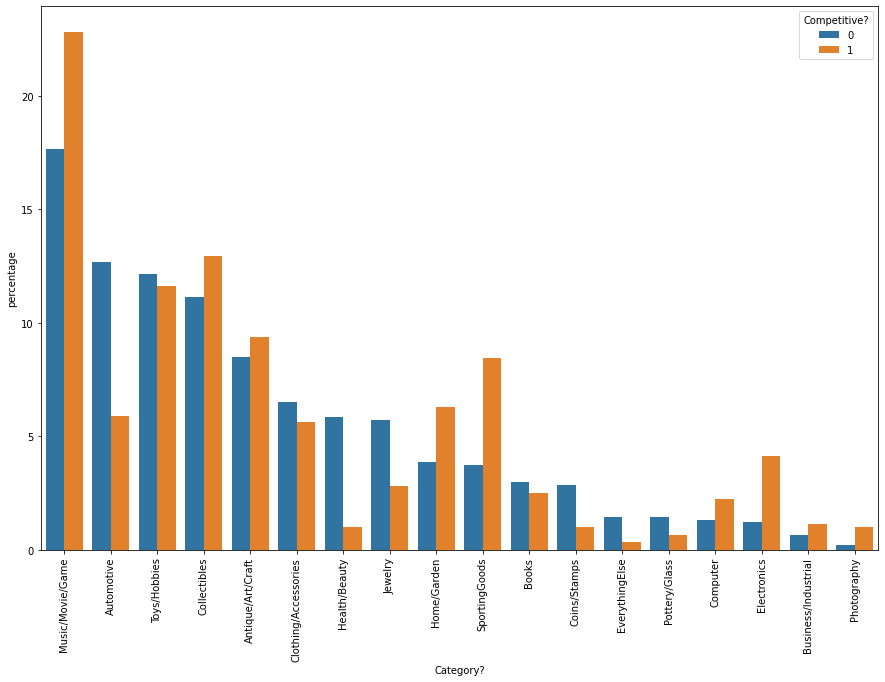

In [24]:
#comparing competitive auctions by category - with duplicates
#some categories may be more competitive than others
counts = (ebay_df.groupby(['Competitive?'])['Category'].value_counts(normalize = True).rename('percentage')
         .mul(100).reset_index())
plt.figure(figsize=(15,10))
sns.barplot(x = 'Category', y ='percentage', hue = 'Competitive?', data = counts)
plt.xlabel('Category?')
plt.legend(title = 'Competitive?')
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Automotive'),
  Text(1, 0, 'Music/Movie/Game'),
  Text(2, 0, 'Collectibles'),
  Text(3, 0, 'Toys/Hobbies'),
  Text(4, 0, 'Antique/Art/Craft'),
  Text(5, 0, 'Clothing/Accessories'),
  Text(6, 0, 'Health/Beauty'),
  Text(7, 0, 'Jewelry'),
  Text(8, 0, 'Home/Garden'),
  Text(9, 0, 'SportingGoods'),
  Text(10, 0, 'Books'),
  Text(11, 0, 'Coins/Stamps'),
  Text(12, 0, 'Computer'),
  Text(13, 0, 'Electronics'),
  Text(14, 0, 'EverythingElse'),
  Text(15, 0, 'Pottery/Glass'),
  Text(16, 0, 'Business/Industrial'),
  Text(17, 0, 'Photography')])

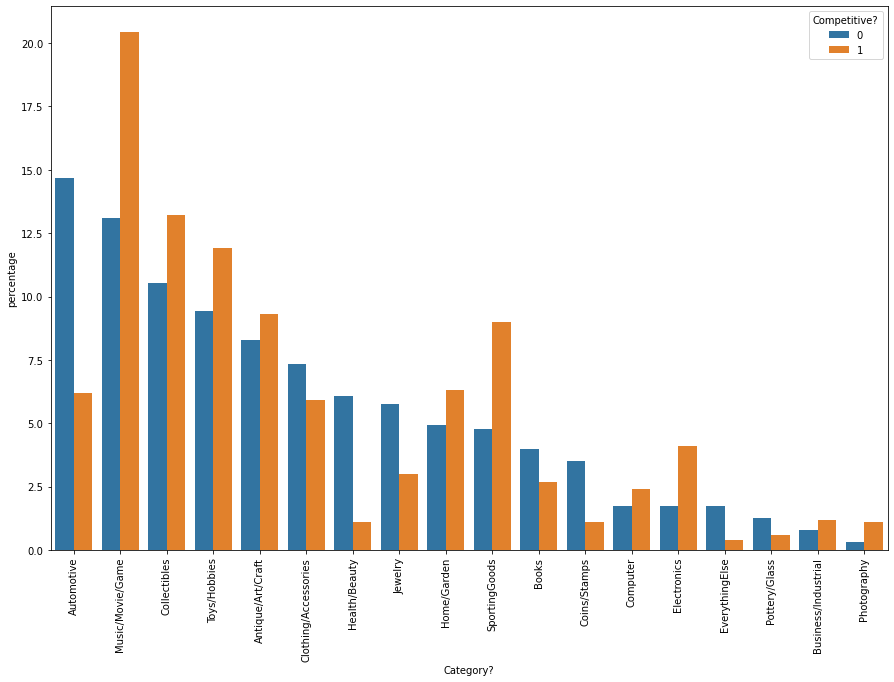

In [25]:
#comparing competitive auctions by category - with no duplicates
counts = (ebay_df_no_duplicates.groupby(['Competitive?'])['Category'].value_counts(normalize = True).rename('percentage')
         .mul(100).reset_index())
plt.figure(figsize=(15,10))
sns.barplot(x = 'Category', y ='percentage', hue = 'Competitive?', data = counts)
plt.xlabel('Category?')
plt.legend(title = 'Competitive?')
plt.xticks(rotation = 90)

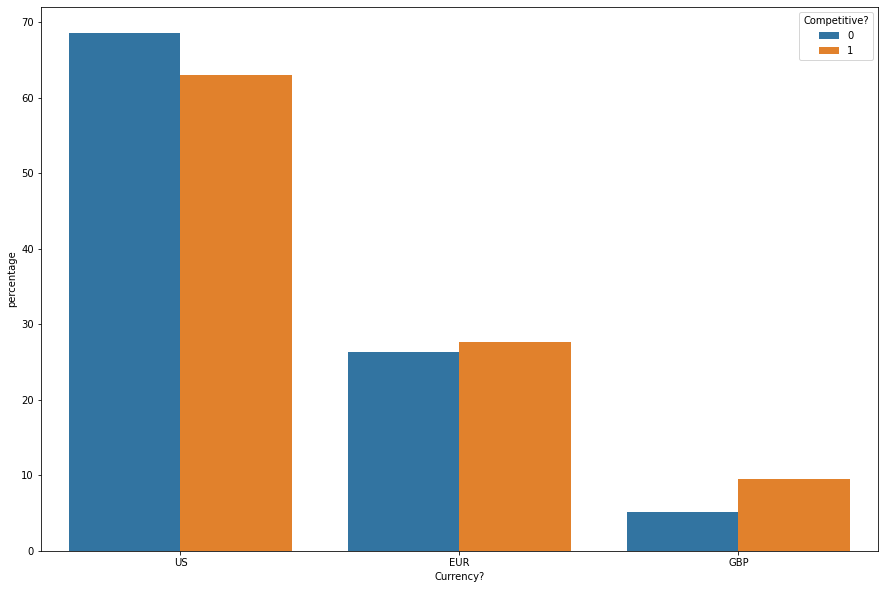

In [26]:
#comparing competitive auctions by currency price - with duplicates
counts = (ebay_df.groupby(['Competitive?'])['Currency'].value_counts(normalize = True).rename('percentage')
         .mul(100).reset_index())
plt.figure(figsize=(15,10))
sns.barplot(x = 'Currency', y ='percentage', hue = 'Competitive?', data = counts)
plt.xlabel('Currency?')
plt.legend(title = 'Competitive?')

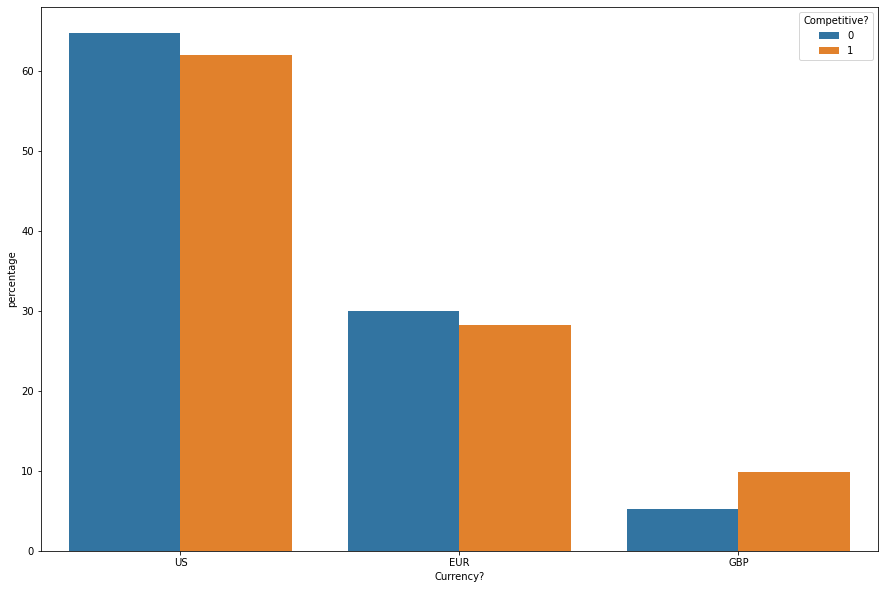

In [27]:
#comparing competitive auctions by currency price - without duplicates
#currency doesn't seem to make a difference
counts = (ebay_df_no_duplicates.groupby(['Competitive?'])['Currency'].value_counts(normalize = True).rename('percentage')
         .mul(100).reset_index())
plt.figure(figsize=(15,10))
sns.barplot(x = 'Currency', y ='percentage', hue = 'Competitive?', data = counts)
plt.xlabel('Currency?')
plt.legend(title = 'Competitive?')

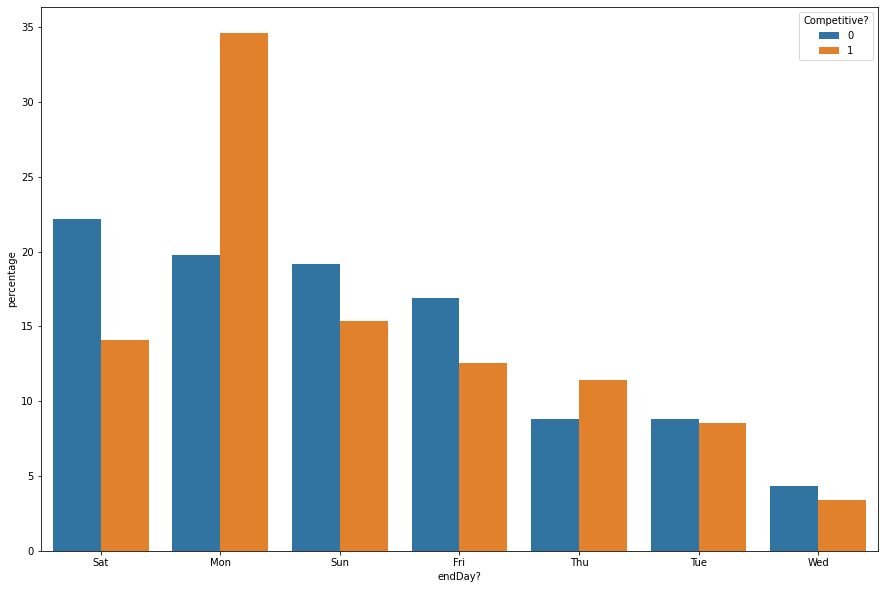

In [28]:
#comparing competitive auctions by endDay - with duplicates
# monday seems to be a good day to end your auction
counts = (ebay_df.groupby(['Competitive?'])['endDay'].value_counts(normalize = True).rename('percentage')
         .mul(100).reset_index())
plt.figure(figsize=(15,10))
sns.barplot(x = 'endDay', y ='percentage', hue = 'Competitive?', data = counts)
plt.xlabel('endDay?')
plt.legend(title = 'Competitive?')

In [29]:
ebay_df['Duration'] = ebay_df['Duration'].astype("object")

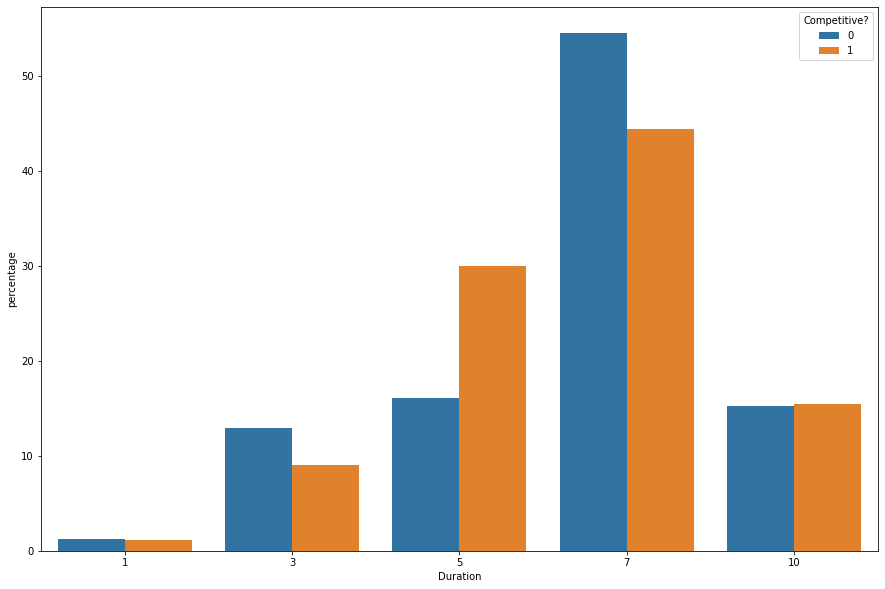

In [30]:
#comparing competitive auctions by duration - with duplicates
#auctions open for 5 days seem to be more competitive, 7 as well but has a higher percentage of not competitive
counts = (ebay_df.groupby(['Competitive?'])['Duration'].value_counts(normalize = True).rename('percentage')
         .mul(100).reset_index())
plt.figure(figsize=(15,10))
sns.barplot(x = 'Duration', y ='percentage', hue = 'Competitive?', data = counts)
plt.xlabel('Duration')
plt.legend(title = 'Competitive?')

Text(0.5, 0, 'Competitive?')

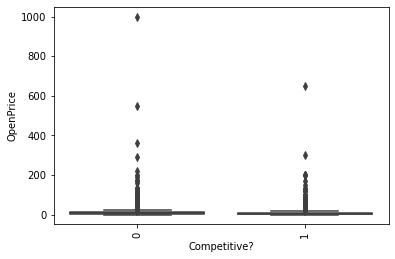

In [31]:
#OpenPrice 
sns.boxplot(x=ebay_df['Competitive?'], y=ebay_df['OpenPrice'])
plt.xticks(rotation = 90)
plt.xlabel("Competitive?")

(-5.0, 100.0)

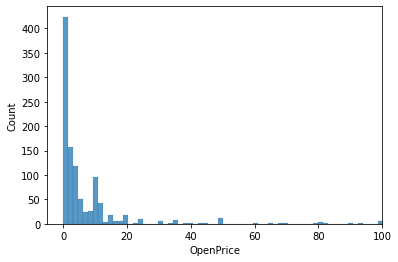

In [32]:
# there are open prices that are higher than 100, cut the x-axis down just to make it more interpretable
ebay_df_comp = ebay_df[ebay_df['Competitive?'] == 1]
fig, ax = plt.subplots()
sns.histplot(data = ebay_df_comp, x = 'OpenPrice')
ax.set_xlim(-5,100)

(-5.0, 100.0)

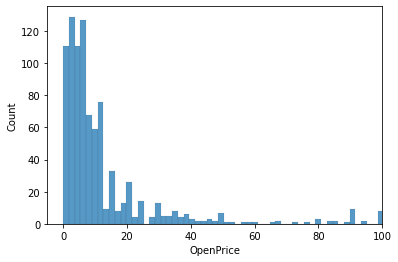

In [33]:
# there are open prices that are higher than 100, cut the x-axis down just to make it more interpretable
# looks like auctions that are not competitive have higher opening prices
ebay_df_comp = ebay_df[ebay_df['Competitive?'] == 0]
fig, ax = plt.subplots()
sns.histplot(data = ebay_df_comp, x = 'OpenPrice')
ax.set_xlim(-5,100)

Text(0.5, 0, 'Competitive?')

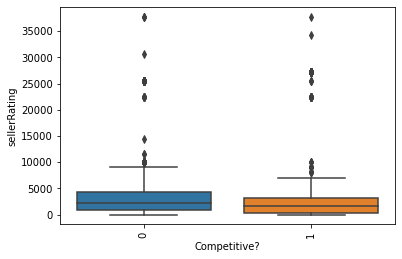

In [34]:
#Rating 
sns.boxplot(x=ebay_df['Competitive?'], y=ebay_df['sellerRating'])
plt.xticks(rotation = 90)
plt.xlabel("Competitive?")

<AxesSubplot:xlabel='sellerRating', ylabel='Count'>

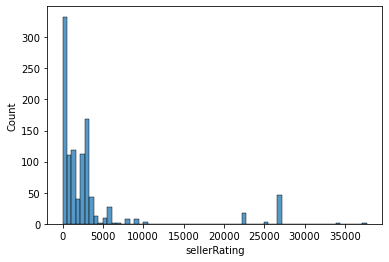

In [35]:
# sellerRating histogram for competitive auctions
ebay_df_comp = ebay_df[ebay_df['Competitive?'] == 1]
fig, ax = plt.subplots()
sns.histplot(data = ebay_df_comp, x = 'sellerRating')

<AxesSubplot:xlabel='sellerRating', ylabel='Count'>

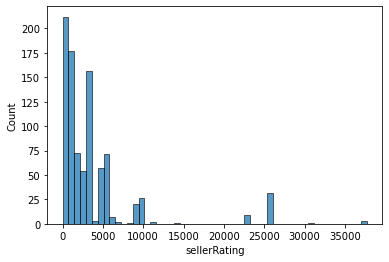

In [36]:
# sellerRating histogram for not-competitive auctions
ebay_df_comp = ebay_df[ebay_df['Competitive?'] == 0]
fig, ax = plt.subplots()
sns.histplot(data = ebay_df_comp, x = 'sellerRating')

Data Engineering

Consider dropping the "ClosePrice" because we do not have this info at the time the auction is being run
However, no need to worry about this because it is part of the next section of the assignment
Keep ClosePrice in the model for now

Keep duplicates in the data set - technically sellers on ebay can put multiple auctions for the same item so cannot tell for sure whether they are duplicates

In [37]:
pd.get_dummies(ebay_df['Category'], prefix = 'category')

,category_Antique/Art/Craft,category_Automotive,category_Books,category_Business/Industrial,category_Clothing/Accessories,category_Coins/Stamps,category_Collectibles,category_Computer,category_Electronics,category_EverythingElse,category_Health/Beauty,category_Home/Garden,category_Jewelry,category_Music/Movie/Game,category_Photography,category_Pottery/Glass,category_SportingGoods,category_Toys/Hobbies
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1968,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1969,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1970,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
pd.get_dummies(ebay_df['Currency'], prefix = 'currency')

,currency_EUR,currency_GBP,currency_US
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
1967,0,0,1
1968,0,0,1
1969,0,0,1
1970,0,0,1


In [39]:
pd.get_dummies(ebay_df['Duration'], prefix = 'duration')

,duration_1,duration_3,duration_5,duration_7,duration_10
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
1967,0,0,1,0,0
1968,0,0,1,0,0
1969,0,0,1,0,0
1970,0,0,0,1,0


In [40]:
pd.get_dummies(ebay_df['endDay'], prefix = 'endDay')

,endDay_Fri,endDay_Mon,endDay_Sat,endDay_Sun,endDay_Thu,endDay_Tue,endDay_Wed
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1967,0,0,0,1,0,0,0
1968,0,0,1,0,0,0,0
1969,0,1,0,0,0,0,0
1970,1,0,0,0,0,0,0


In [41]:
ebay_df_final = pd.concat([ebay_df, pd.get_dummies(ebay_df['Category'], prefix = 'category'),  pd.get_dummies(ebay_df['Currency'], prefix = 'currency'), pd.get_dummies(ebay_df['Duration'], prefix = 'duration'),pd.get_dummies(ebay_df['endDay'], prefix = 'endDate')], axis = 1)

In [42]:
ebay_df_final.drop(['Category', 'Currency', 'Duration', 'endDay'], axis = 1, inplace = True)

In [43]:
ebay_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sellerRating                   1972 non-null   int64  
 1   ClosePrice                     1972 non-null   float64
 2   OpenPrice                      1972 non-null   float64
 3   Competitive?                   1972 non-null   int64  
 4   category_Antique/Art/Craft     1972 non-null   uint8  
 5   category_Automotive            1972 non-null   uint8  
 6   category_Books                 1972 non-null   uint8  
 7   category_Business/Industrial   1972 non-null   uint8  
 8   category_Clothing/Accessories  1972 non-null   uint8  
 9   category_Coins/Stamps          1972 non-null   uint8  
 10  category_Collectibles          1972 non-null   uint8  
 11  category_Computer              1972 non-null   uint8  
 12  category_Electronics           1972 non-null   u

In [44]:
# we do not know the closing price when an ebay auction is made live so will drop this column
#save this for next part
#ebay_df_final.drop(['ClosePrice'], axis = 1 , inplace = True)

In [45]:
#declare X dataframe
X = ebay_df_final.drop(['Competitive?'], axis = 1)
y = ebay_df_final['Competitive?']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [47]:
fullClassTree = DecisionTreeClassifier(min_samples_leaf = 50, random_state = 42)

In [48]:
fullClassTree.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=50, random_state=42)

In [49]:
y_predicted = fullClassTree.predict(X_test)

In [50]:
fullClassTree.score(X_test, y_test)

0.8276299112801014

In [51]:
fullClassTree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [52]:
classificationSummary(y_train, fullClassTree.predict(X_train))

Confusion Matrix (Accuracy 0.8436)

       Prediction
Actual   0   1
     0 488  59
     1 126 510


In [53]:
fullClassTree.tree_.node_count

27

In [54]:
fullClassTree.tree_.max_depth

6

[Text(614.4642857142858, 1009.5428571428572, 'OpenPrice <= 3.615\ngini = 0.497\nsamples = 1183\nvalue = [547, 636]\nclass = C'),
 Text(332.14285714285717, 854.2285714285715, 'ClosePrice <= 3.645\ngini = 0.384\nsamples = 537\nvalue = [139, 398]\nclass = C'),
 Text(199.28571428571428, 698.9142857142858, 'OpenPrice <= 2.115\ngini = 0.451\nsamples = 210\nvalue = [138, 72]\nclass = NC'),
 Text(132.85714285714286, 543.6, 'ClosePrice <= 1.24\ngini = 0.497\nsamples = 146\nvalue = [79, 67]\nclass = NC'),
 Text(66.42857142857143, 388.28571428571433, 'gini = 0.278\nsamples = 72\nvalue = [60, 12]\nclass = NC'),
 Text(199.28571428571428, 388.28571428571433, 'gini = 0.382\nsamples = 74\nvalue = [19, 55]\nclass = C'),
 Text(265.7142857142857, 543.6, 'gini = 0.144\nsamples = 64\nvalue = [59, 5]\nclass = NC'),
 Text(465.0, 698.9142857142858, 'OpenPrice <= 2.995\ngini = 0.006\nsamples = 327\nvalue = [1, 326]\nclass = C'),
 Text(398.57142857142856, 543.6, 'gini = 0.0\nsamples = 276\nvalue = [0, 276]\ncla

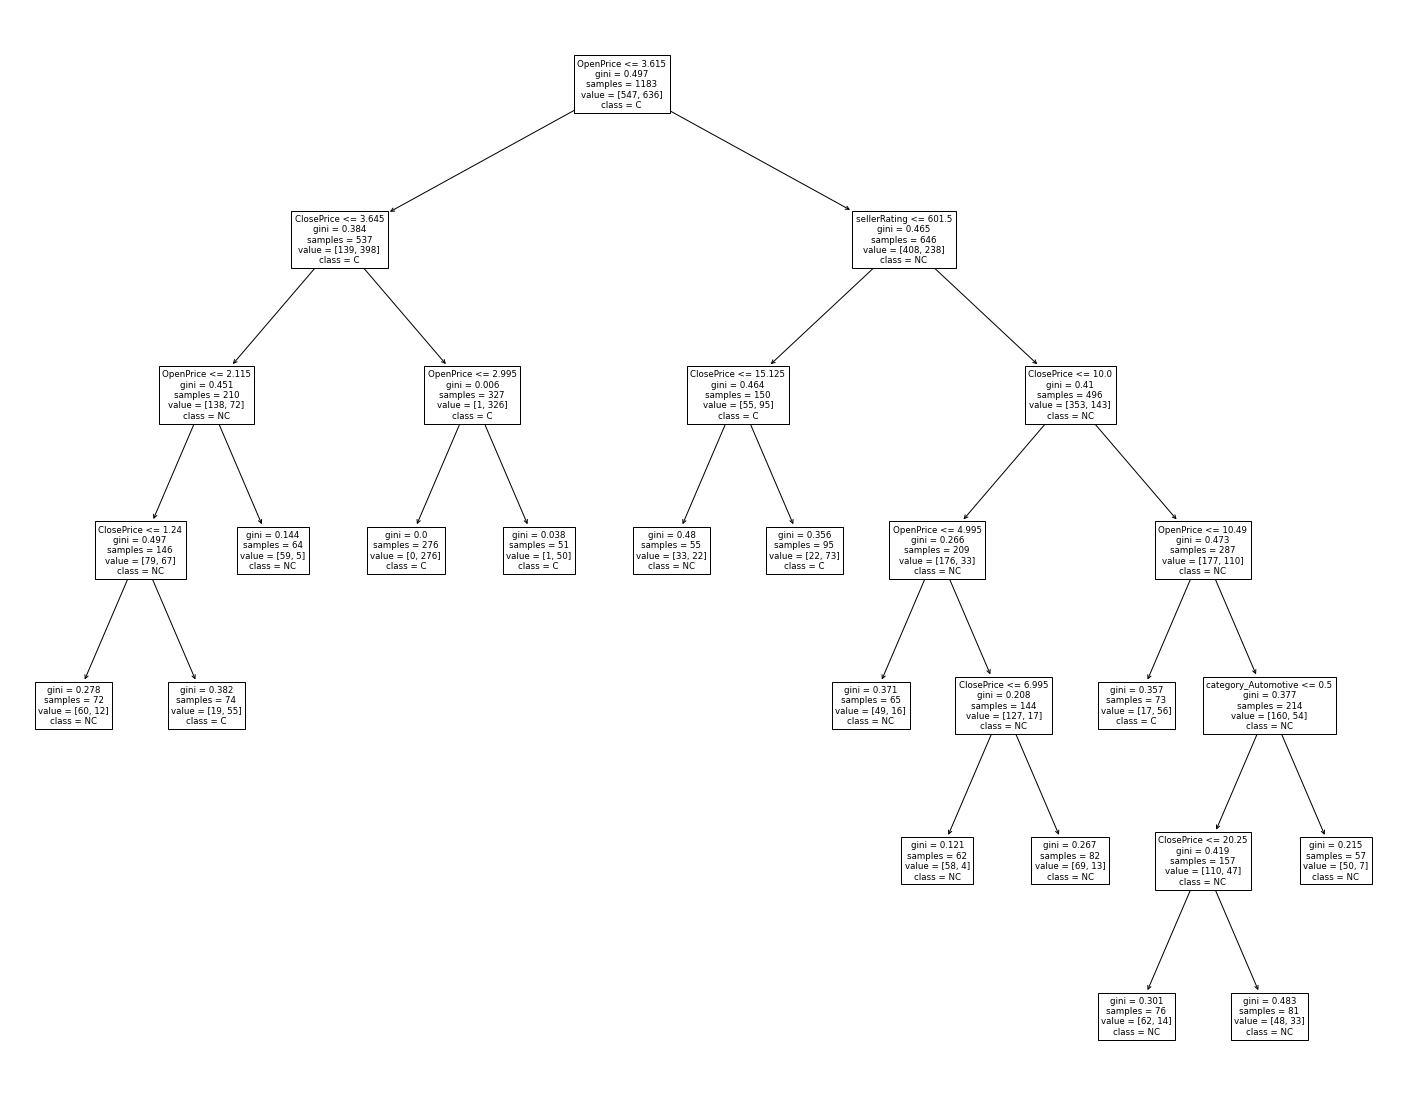

In [55]:
plt.figure(figsize=(25,20))
tree.plot_tree(fullClassTree, feature_names = X.columns, class_names = ['NC', 'C'])

In [56]:
export_graphviz(fullClassTree, out_file = 'fullClassTree_v1.dot', feature_names = X_train.columns)

Can visualize the .dot file by copying the text into: http://webgraphviz.com/

In [57]:
#no limit on number of min_samples to see what we get, accuracy not too too much better
fullClassTree_v2 = DecisionTreeClassifier(random_state = 42)
fullClassTree_v2.fit(X_train, y_train)
y_predicted = fullClassTree_v2.predict(X_test)
fullClassTree_v2.score(X_test, y_test)

0.8808618504435995

In [58]:
export_graphviz(fullClassTree_v2, out_file = 'fullClassTree_v2.dot', feature_names = X_train.columns)

In [59]:
classificationSummary(y_train, fullClassTree_v2.predict(X_train))

Confusion Matrix (Accuracy 0.9941)

       Prediction
Actual   0   1
     0 547   0
     1   7 629


Comparing the decision tree for having a limit of 50 observations in nodes in order to split them to having no restriction the accuracy is not much better, only 6 percent, probably because it overfits the training data as shown in the confusion matrix above with only 7 incorrect labels if no restrictions placed on min_sample_leafs

Describe interesting/unexpected and uninteresting (=rather obvious) information that these rules provide?
Assuming we have the ClosePrice at time of auction, which we wouldn't
- Splits were done mostly on continuous variables rather than the dummy variables included (i.e., OpenPrice, ClosePrice and SellerRating)
- If the OpenPrice is less than 3.615 dollars then the sellerRating does not seem to matter in terms of auction competitiveness, buyers will go based on price
- Items that close at less than 1.24 dollars are not competitive
- SellerRating only matters on products that are priced above 3.615
- General trend seems to be the cheaper it is the less competitive it is
- ^above was done quickly, should look into it more

Suppose I had to slightly reduce the number of predictors due to software limitations or for clarity of
presentation, which would be (a) good variable(s) to choose?
- If I had to reduce the number of predictors I would probably go with just OpenPrice and SellerRating since these splits were early on splits meaning they likely have more ability to homogenize nodes. Would not include ClosePrice since this data is not available at time of auction posting

Is this model practical for predicting the outcome of a new auction?
- No this model is not practical for predicting the outcome of a new auction since it depends on hte ClosePrice which will only become available after the auction has been completed and therefore predicting whether an auction will be competitive or not is no longer useful at that point. We want to predict whether an auction will be competitive or not when the auction is posted for new auctions.

In [60]:
X1 = ebay_df_final.drop(['ClosePrice', 'Competitive?'], axis = 1)
y1 = ebay_df_final['Competitive?']

In [64]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.4, random_state = 42)

In [66]:
fullClassTree_noClosePrice = DecisionTreeClassifier(min_samples_leaf = 50, random_state = 42)
fullClassTree_noClosePrice.fit(X1_train, y1_train)
y_predicted = fullClassTree_noClosePrice.predict(X1_test)
fullClassTree_noClosePrice.score(X1_test, y1_test)

0.7110266159695817

In [70]:
# training data confusion matrix
classificationSummary(y1_train, fullClassTree_noClosePrice.predict(X1_train))

Confusion Matrix (Accuracy 0.7287)

       Prediction
Actual   0   1
     0 363 184
     1 137 499


In [71]:
#testing data confusion matrix
classificationSummary(y1_test, fullClassTree_noClosePrice.predict(X1_test))

Confusion Matrix (Accuracy 0.7110)

       Prediction
Actual   0   1
     0 233 126
     1 102 328


So the accuracy gets worse for the test data, but also for the training data however it is a more realistic model for
new auction competitiveness

In [68]:
export_graphviz(fullClassTree_noClosePrice, out_file = 'fullClassTree_noClosePrice.dot', feature_names = X1_train.columns)

Open fullClassTree_noClosePrice.dot and copy the text into http://webgraphviz.com/ to visualize the tree

C:\Users\matth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='OpenPrice', ylabel='sellerRating'>

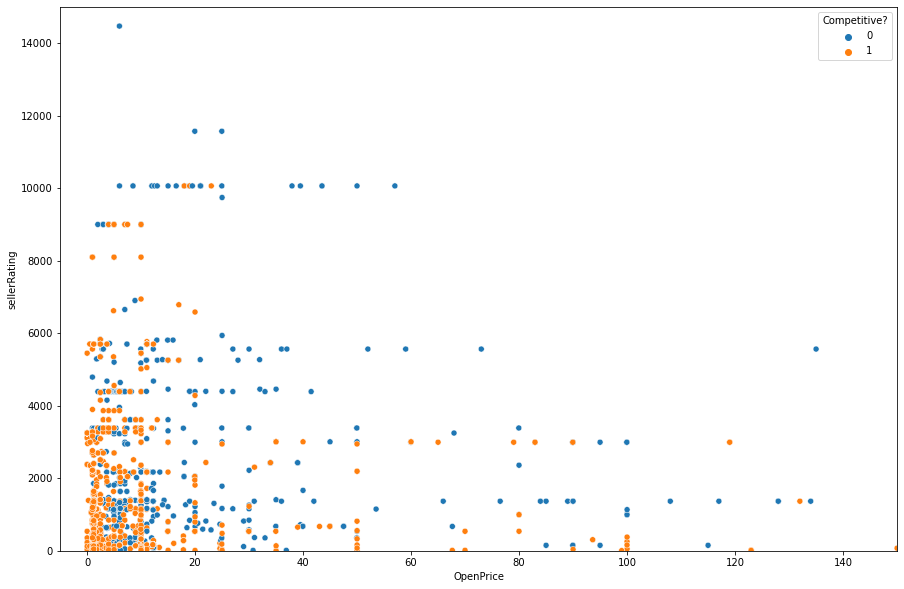

In [91]:
#create a scatterplot for two best quantitative predictors
fig, ax = plt.subplots(figsize = ( 15 , 10 ))
ax.set_xlim(-5,150) #ranges from 0 to 1000, however majority are fewer than 200, so will limit for visualizing
ax.set_ylim(-5, 15000) #ranges from 0 to 35000+, put majority are less than 15000 so will limit for visualizing
sns.scatterplot(ebay_df_final['OpenPrice'], ebay_df_final['sellerRating'], hue = ebay_df_final['Competitive?'])

Interpreatation of above: Does the splitting seem reasonable with respect to the meaning of the two predictors? Does
it seem to do a good job of separating the two classes?

So looks like low sellerRating and low OpenPrice are more competitive, the interpreation of SellerRating still not sure
Low price I could see why its competitive since people tend to purchase cheaper items on eBay, but I would thikn higher SellerRating means better seller quality
Higher prices tend to be not as competitive it looks like (just barely), makes sense since it may be niche products that not many people are interested in buying

I think it still isn't very distinct the splitting based on these two quantitative variables since there is quite a lot of overlap between competitive and not competitive auctions based on SellerRating and OpenPrice

Examine the classification table for the tree. What can you say about the predictive performance of this model?
It isn't great, test accuracy of about 71%, this is better than a naive model because the true rate is close to 50-50 in the training data set so it is a little better
